## Problem Set #5 NYU
Juan Martin Morelli
N12699038

**Assignment:**

_Repeat PS#4 but this time in Julia. Use 10,000 simulations._
_The AR(1) specification was_

$$X_{t+1}=\alpha X_{t} + \beta + \sigma W_{t+1} $$
_where $W_{t+1}\sim N(0,1)$._

_Recall the values of $\alpha=[0.5, 0.6, 0.7, 0.8, 0.9]$._

_The sample sizes should go from 50 to 500._

In [4]:
addprocs(4)

# Spencer's comment: 
# By default code only runs on process 1. If you want it available everywhere
# you need to use `@everywhere code`. To make multiple things avialable
# on all processes the easiest thing to do is `@everywhere begin CODE end`
# notice the `end` the bottom of this cell
# see http://docs.julialang.org/en/release-0.4/manual/parallel-computing/#code-availability-and-loading-packages
@everywhere begin
# Generate a type to capture the relevant structure of the problem set
type AR1
    α::Float64 # AR1 coefficient
    β::Float64 # Constant
    σ::Float64 # s.d. of the innovation process
    x0::Float64 # Initial value for simulations
    N::Int # Sample size
    S::Int # Number of simulations
end


# Function for iteration as in the lecture notes
iter(ar1::AR1, x) = ar1.β + ar1.α*x + ar1.σ*randn()


# Function to generate an AR1 process  
function dgp_ar1(ar1::AR1)
    capT = ar1.N
    out = Array(typeof(ar1.x0), capT)
    out[1] = ar1.x0

    for t = 2:capT
        out[t] = iter(ar1, out[t-1])
    end
    out
end


# Function to estimate an AR1
function ar1_est(ar1::AR1, vals::Vector{Float64})
    X = hcat(ones(vals[1:end-1]),vals[1:end-1])
    Y = vals[2:end]
    bhat = \(*(X',X),*(X',Y))
end


# Embeding function to simulate for each α and each N
function simul(ar1::AR1)
    S = ar1.S
    bh = 0.0
    for i=1:S
        vals = dgp_ar1(ar1)
        bhh = ar1_est(ar1, vals)
        bh += bhh[2]
    end
    
    bhat = bh/S
end

end  # ending the @everywhere

In [33]:
# Following Spencer's advice, I put the main part of the code inside a function
# to improve performance.
function main(alphas::Array{Float64,1}, Ns::Vector{Int}) # Define the values for α and N
    # Pre define the array which will contain the bias
    bias = SharedArray(Float64,(length(Ns), length(alphas)))

    # Just run the loop for each α and each N
    # In principle not clear where it is better to put the parallel command
    for i_α in eachindex(alphas)
        α = alphas[i_α]
       @sync @parallel for i_N in eachindex(Ns)
            N = Ns[i_N]
            ar1 = AR1(α, 0., 0.3, 0.5, N, 10000)
            bhat = simul(ar1)
            bias[i_N, i_α] = bhat - α
        end
    end
    return bias
end

main (generic function with 1 method)

In [37]:
# Define the values for α and N
alphas = [0.5, 0.6, 0.7, 0.8, 0.9]
Ns = convert(Array{Int},collect(linspace(50,500,10)))

# Run main function
@time bias = main(alphas,Ns)

  3.463950 seconds (39.70 k allocations: 3.028 MB)


10x5 SharedArray{Float64,2}:
 -0.0475032   -0.0556263   -0.0639158   -0.0737902   -0.0856635 
 -0.0234822   -0.0288129   -0.0302684   -0.0346301   -0.0399657 
 -0.0168837   -0.0188875   -0.0214857   -0.0231234   -0.0268942 
 -0.0125912   -0.0146182   -0.0153369   -0.0173793   -0.0194531 
 -0.0106531   -0.0107022   -0.0121445   -0.0139997   -0.0153692 
 -0.0080459   -0.00919726  -0.0106222   -0.0110398   -0.0126683 
 -0.00716636  -0.00802857  -0.00898891  -0.00970638  -0.0108145 
 -0.00553389  -0.00717958  -0.00760913  -0.00868236  -0.00981992
 -0.00555053  -0.00617974  -0.00722007  -0.00679418  -0.00859164
 -0.00491585  -0.00566058  -0.00645823  -0.00741259  -0.00763389

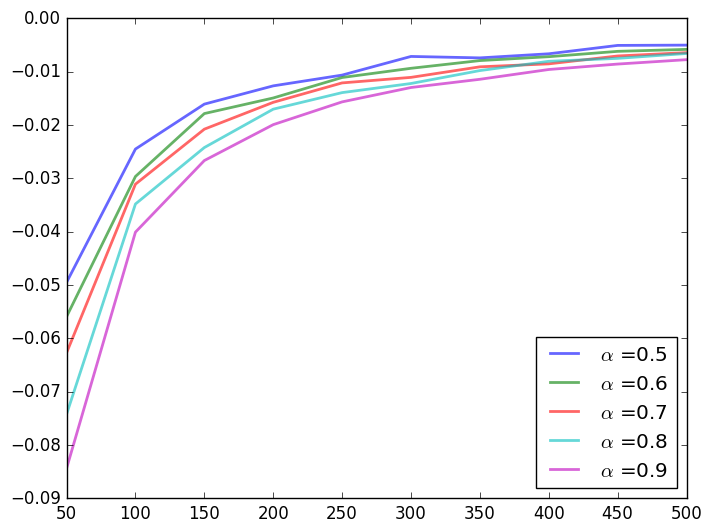

PyObject <matplotlib.legend.Legend object at 0x325672cd0>

In [35]:
using PyPlot

fig, ax = subplots()
for (i, ai) in enumerate(alphas)
    ax[:plot](Ns, bias[:,i], linewidth=2, alpha=0.6, label=L"$\alpha$ =""$ai")
end
ax[:legend](loc=4)